# Understanding YOLO Output

## Yolo output have 3 scale and each scale have 3 anchor
(x,y, (anchor*5+class) )
(x,y,anchor,5+class) 5 - > consist of (x,y,w,h,conf)

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda ,Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from model.core import yolo_head,preprocess_true_boxes, yolo_loss
from model.yolo3 import yolo_body, tiny_yolo_body
from model.utils import get_random_data

from tqdm import tqdm
import time

In [28]:

def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [29]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    '''data generator for fit_generator'''

    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
       # print(image_data.shape)
        m_true = model.predict(image_data)
     

        yield image_data , box_data , y_true , m_true  #, np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model)

In [30]:
train_path = '2007_train.txt'
val_path = '2007_val.txt'
# test_path = '2007_test.txt'
log_dir = 'logs/000/'
classes_path = 'class/voc_classes.txt'
anchors_path = 'anchors/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)

input_shape = (416,416) # multiple of 32, hw

with open(train_path) as f:
    train_lines = f.readlines()

with open(val_path) as f:
    val_lines = f.readlines()

# with open(test_path) as f:
#     test_lines = f.readlines()

num_anchors = len(anchors)
image_input = Input(shape=(416, 416, 3))
model = yolo_body(image_input, num_anchors//3, num_classes)
model.load_weights("model_data/trained_weights_final.h5")

yolo3 = Reshape((13, 13, 3, 25))(model.layers[-3].output)
yolo2 = Reshape((26, 26, 3, 25))(model.layers[-2].output)
yolo1 = Reshape((52, 52, 3, 25))(model.layers[-1].output)


model = Model( inputs= model.input , outputs=[yolo3,yolo2,yolo1] )

batch_size = 1

In [31]:

        # create an hdf5 file
train_size = 5 #len(train_lines)
image = {}
box = {}
train_logits = {}
model_logits = {}

print( "total "+ str(len(train_lines)) + " loop "+ str( train_size ) )

i = 0 #step
for  img,box_data,flogits,mlogits in data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes,model) : 
    #x , y = dat
    image[i] = img
    box[i] = box_data
    train_logits[i] = flogits
    model_logits[i] = mlogits

    i+=1
    if i>= train_size:#(len(train_lines)) :
        break

total 2501 loop 5


In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [33]:
ch = 3
obj = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

In [34]:
box[ch]

array([[[ 74., 112., 198., 258.,  18.],
        [209., 162., 254., 224.,  18.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]]])

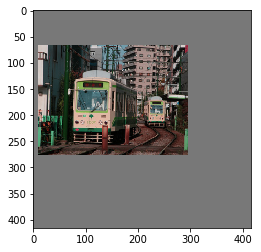

In [35]:
plt.imshow(image[ch][0])
plt.show()

In [36]:
train_logits[ch][0].shape

(1, 13, 13, 3, 25)

In [37]:
train_logits[ch][1].shape

(1, 26, 26, 3, 25)

In [38]:
train_logits[ch][2].shape

(1, 52, 52, 3, 25)

In [39]:
np.set_printoptions(threshold=np.inf)

### Real Dataset

Large Object (1,13,13,3,25) , Medium Object (1,26,26,3,25),Small Object (1,52,52,3,25)

In [88]:
lrg = train_logits[ch][0]
med = train_logits[ch][1]
sml = train_logits[ch][2]

In [89]:
lrgm = model_logits[ch][0]
medm = model_logits[ch][1]
smlm = model_logits[ch][2]

Change the Variable to see other scale

In [133]:
arrpl = lrg
arrpl[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxl = np.where(arrpl[:,:,:,:,:] > 0 )
boxl

(array([0, 0, 0, 0, 0, 0], dtype=int64),
 array([5, 5, 5, 5, 5, 5], dtype=int64),
 array([4, 4, 4, 4, 4, 4], dtype=int64),
 array([1, 1, 1, 1, 1, 1], dtype=int64),
 array([ 0,  1,  2,  3,  4, 23], dtype=int64))

x,y,w,h,p and class

In [135]:
box = boxl
arrp= arrpl
for i in range(1,( len(box[0])//5 +1) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    if(arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],4] > 0.5):
        print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
        print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
        print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
        obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
        print( "{} = {}".format(obnum, obj[ obnum ] ) )
        print("-------------------------------------------------------")

(0,5,4,1)
[0.32692307 0.44471154 0.29807693 0.35096154 1.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
18 = train
-------------------------------------------------------


In [136]:
arrpm = med
boxm = np.where(arrpm[:,:,:,:,:] > 0 )
boxm

(array([0, 0, 0, 0, 0, 0], dtype=int64),
 array([12, 12, 12, 12, 12, 12], dtype=int64),
 array([14, 14, 14, 14, 14, 14], dtype=int64),
 array([0, 0, 0, 0, 0, 0], dtype=int64),
 array([ 0,  1,  2,  3,  4, 23], dtype=int64))

In [137]:
box = boxm
arrp= arrpm
for i in range(1,( len(box[0])//5 +1) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    if(arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],4] > 0.5):
        print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
        print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
        print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
        obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
        print( "{} = {}".format(obnum, obj[ obnum ] ) )
        print("-------------------------------------------------------")

(0,12,14,0)
[0.55528843 0.46394232 0.10817308 0.14903846 1.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
18 = train
-------------------------------------------------------


In [117]:
arrps = sml
boxs = np.where(arrps[:,:,:,:,:] > 0 )
boxs

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [118]:
box = boxs
arrp= arrps
for i in range(1,( len(box[0])//5 +1) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    if(arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],4] > 0.5):
        print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
        print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
        print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
        obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
        print( "{} = {}".format(obnum, obj[ obnum ] ) )
        print("-------------------------------------------------------")

### Model Predict

Large Object (1,13,13,3,25) , Medium Object (1,26,26,3,25),Small Object (1,52,52,3,25)

Change the Variable to see other scale

In [138]:
arrplm = lrgm
arrplm[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxlm = np.where(arrplm[:,:,:,:,:] > 0 )
boxlm

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

x,y,w,h,p and class

In [144]:
box = boxlm
arrp= arrplm
for i in range(1,( len(box[0])//5 +1) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    if(arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],4] > 0.5):
        print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
        print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
        objprob = arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]
        print( objprob )
        obnum =  np.argmax( objprob ) 
        objsum = sum(objprob)
        print( "{} = {} sum > {}".format(obnum, obj[ obnum ],objsum ) )
        print("-------------------------------------------------------")

(0,5,4,0)
[-1.0401597   1.5080786   0.0144885   0.36233675  2.473475  ]
[-10.680081   -8.512967   -8.71004   -12.61903   -10.8656025   1.9891305
 -10.679342   -8.588655  -11.542575  -10.507843  -10.061315  -10.297377
 -10.780691   -9.6170845 -10.433167   -9.862961   -8.900862  -10.067838
  -1.7579749  -9.717721 ]
5 = bus sum > -182.21399664878845
-------------------------------------------------------
(0,5,4,1)
[-0.69594276  1.9425054  -0.11307011 -0.3531402   3.626433  ]
[ -8.201051    -7.6495657   -8.9535055   -8.728272    -9.22999
   0.94472843 -10.148548    -9.203486   -10.193963   -11.23032
 -11.726544   -10.822726    -9.273732   -11.675693   -10.975901
  -9.161951    -9.800882   -10.296046     0.28422534  -8.503567  ]
5 = bus sum > -174.54679065942764
-------------------------------------------------------
(0,6,4,0)
[-0.9473663  -2.380808    0.01883296  0.31325942  1.608785  ]
[-10.352446    -8.715486    -9.754833   -15.033544   -10.193458
  -0.07104211  -7.2981524   -7.636348   

IndexError: index 1030 is out of bounds for axis 1 with size 1030

In [140]:
arrpmm = medm
arrpmm[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxmm = np.where(arrpmm[:,:,:,:,:] > 0 )
boxmm

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

x,y,w,h,p and class

In [141]:
box = boxmm
arrp= arrpmm
for i in range(1,( len(box[0])//5 +1) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    if(arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],4] > 0.5):
        print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
        print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
        print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
        obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
        print( "{} = {}".format(obnum, obj[ obnum ] ) )
        print("-------------------------------------------------------")

(0,11,14,0)
[ 0.04511976  2.6447208   0.2749709  -0.03568717  1.019548  ]
[ -9.232708   -7.2413793 -11.606275   -7.736935   -6.868185    3.6626863
  -7.8790727 -12.107138   -9.78543   -10.354314  -10.00971   -15.024335
  -9.806591  -11.831197   -8.24941    -7.645801  -12.342602  -10.221468
  -2.1844966  -6.570325 ]
5 = bus
-------------------------------------------------------
(0,11,14,1)
[ 0.3246505   2.022627   -0.29841876  0.30571824  1.2651998 ]
[-10.597515   -9.376617  -12.846068   -8.070078   -7.226884    5.751089
 -10.84545   -10.631691  -13.355166   -8.188809  -11.244626  -16.360025
 -10.306093   -9.147222   -9.307776   -6.5165596 -10.495109  -10.303293
  -2.9590614  -5.306634 ]
5 = bus
-------------------------------------------------------
(0,12,14,0)
[ 2.2844113e-01 -2.2087867e+00  3.1257713e-01  1.8568377e-03
  3.7518139e+00]
[ -9.298257   -7.810275  -12.256091   -8.537503   -7.3975573   3.639561
  -6.4030886 -13.606927  -11.075677  -11.18914    -9.54751   -15.486038
  -9.

In [142]:
arrpsm = smlm
arrpsm[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxsm = np.where(arrpsm[:,:,:,:,:] > 0 )
boxsm

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

x,y,w,h,p and class

In [143]:
box = boxsm
arrp= arrpsm
for i in range(1,( len(box[0])//5 +1) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    if(arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],4] > 0.5):
        print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
        print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
        print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
        obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
        print( "{} = {}".format(obnum, obj[ obnum ] ) )
        print("-------------------------------------------------------")